In [ ]:
%pip install onedrivedownloader matplotlib

In [ ]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from onedrivedownloader import download

download('https://unimore365-my.sharepoint.com/:u:/g/personal/215580_unimore_it/EXhnxAKIfcdIqSRJoFc_C6EBCT6S0CNLOYFW3ShqivC46w?e=Ii4NOp',
                                                      filename='./mnist/mnist_mnist.zip',
                                                      unzip=True)

def load_mnist_digits():
    """
    Loads mnist (original, with digits).

    Returns
    -------
    tuple:
        x_train with shape(n_train_samples, h, w)
        y_train with shape(n_train_samples,)
        x_test with shape(n_test_samples, h, w)
        y_test with shape(n_test_samples,)
    """

    x_train = np.load('mnist/x_train.npy')
    y_train = np.load('mnist/y_train.npy')

    x_test = np.load('mnist/x_test.npy')
    y_test = np.load('mnist/y_test.npy')

    label_dict = {i: str(i) for i in range(0, 10)}

    return x_train, y_train, x_test, y_test, label_dict


def load_mnist(threshold=0.5):
    """
    Loads MNIST data (either digits or fashion) and returns it binarized.

    Parameters
    ----------
    threshold: float
        a threshold in [0, 1] to binarize w.r.t.

    Returns
    -------
    tuple:
        x_train with shape(n_train_samples, h, w)
        y_train with shape(n_train_samples,)
        x_test with shape(n_test_samples, h, w)
        y_test with shape(n_test_samples,)
    """

    x_train, y_train, x_test, y_test, label_dict = load_mnist_digits()

    x_train = np.float32(x_train) / 255.
    x_train[x_train >= threshold] = 1
    x_train[x_train < threshold] = 0

    x_test = np.float32(x_test) / 255.
    x_test[x_test >= threshold] = 1
    x_test[x_test < threshold] = 0

    return x_train, y_train, x_test, y_test, label_dict

In [9]:
"""
Class that models a Naive Bayes Classifier
"""

import numpy as np


class NaiveBayesClassifier:
    """
    Naive Bayes Classifier.
    Training:
    For each class, a naive likelihood model is estimated for P(X/Y),
    and the prior probability P(Y) is computed.
    Inference:
    performed according with the Bayes rule:
    P = argmax_Y (P(X/Y) * P(Y))
    or
    P = argmax_Y (log(P(X/Y)) + log(P(Y)))
    """

    def __init__(self):
        """
        Class constructor
        """

        self._classes = None
        self._n_classes = 0

        self._eps = np.finfo(np.float32).eps

        # array of classes prior probabilities
        self._class_priors = []

        # array of probabilities of a pixel being active (for each class)
        self._pixel_probs_given_class = []

    def fit(self, X, Y):
        """
        Computes, for each class, a naive likelihood model (self._pixel_probs_given_class),
        and a prior probability (self.class_priors).
        Both quantities are estimated from examples X and Y.

        Parameters
        ----------
        X: np.array
            input MNIST digits. Has shape (n_train_samples, h, w)
        Y: np.array
            labels for MNIST digits. Has shape (n_train_samples,)
        """

        # trovare i parametri del modello per ogni classe per la gaussiana
        # trovare la probabilità a priori per ogni classe (numero di esempi di quella classe / numero totale di esempi)
        # trovare la varianza per ogni pixel per ogni classe _pixel_means_given_class
        # _pixel_std_given_class = np.sqrt(_pixel_vars_given_class)

        # LDA
        # trovare la varianza per ogni pixel per ogni classe _pixel_vars_given_class
        # global_std_dev = np.stack(_pixel_std_given_class).mean(axis=0)
        # _pixel_vars_given_class = np.stack(_pixel_vars_given_class)

        yclass, counts = np.unique(Y, return_counts=True)

        self._classes = yclass
        self._n_classes = len(yclass)
        self._class_priors = counts / X.shape[0]
        self._pixel_probs_given_class = [np.mean(X[Y == c], axis=0) for c in yclass]

    def predict(self, X, return_pred=False):
        """
        Performs inference on test data.
        Inference is performed according with the Bayes rule:
        P = argmax_Y (log(P(X/Y)) + log(P(Y)) - log(P(X)))

        Parameters
        ----------
        X: np.array
            MNIST test images. Has shape (n_test_samples, h, w).

        Returns
        -------
        prediction: np.array
            model predictions over X. Has shape (n_test_samples,)
        """

        n_test_images = X.shape[0]
        num_pixels_per_image = X.shape[1]

        results = np.zeros((n_test_images, self._n_classes))

        mask_one = X == 1.0
        mask_zero = X == 0.0

        for i in range(self._n_classes):
            model_of_i = self._pixel_probs_given_class[i]
            model_of_i = model_of_i.reshape((1, num_pixels_per_image))

            pixel_likelihoods = mask_one * model_of_i + mask_zero * (1.0 - model_of_i)
            pixel_likelihoods_log = np.log(pixel_likelihoods + self._eps)
            class_likelihoods_log = np.sum(pixel_likelihoods_log, axis=1)

            class_prior_log = np.log(self._class_priors[i])

            final_log_score = class_likelihoods_log + class_prior_log
            results[:, i] = final_log_score

        pred = np.argmax(results, axis=1)

        return (pred, results) if return_pred else pred

    @staticmethod
    def _estimate_pixel_probabilities(images):
        """
        [OPTIONAL!]
        Estimates pixel probabilities from data.

        Parameters
        ----------
        images: np.array
            images to estimate pixel probabilities from. Has shape (n_images, h, w)

        Returns
        -------
        pix_probs: np.array
            probabilities for each pixel of being 1, estimated from images.
            Has shape (h, w)
        """
        return None

    def get_log_likelihood_under_model(self, images, model):
        """
        [OPTIONAL!]
        Returns the likelihood of many images under a certain model.
        Naive:
        the likelihood of the image is the product of the likelihood of each pixel.
        or
        the log-likelihood of the image is the sum of the log-likelihood of each pixel.

        Parameters
        ----------
        images: np.array
            input images. Having shape (n_images, h, w).
        model: np.array
            a model of pixel probabilities, having shape (h, w)

        Returns
        -------
        lkl: np.array
            the likelihood of each pixel under the model, having shape (h, w).
        """
        return None

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x_train, y_train, x_test, y_test, label_dict = load_mnist(threshold=0.5)

print(f"Training set -> number of examples: {len(x_train)}")
print(f"Test set -> number of examples: {len(x_test)}")
print("-" * 30)
print(f"X -> shape: {x_train.shape}")
print(f"X -> dtype: {x_train.dtype}")
print(f"X -> min: {x_train.min()}")
print(f"X -> max: {x_train.max()}")
print(f"X -> values: {np.unique(x_train)}")
print("-" * 30)
print(f"Classes: {(np.unique(y_train))}")

Training set -> number of examples: 60000
Test set -> number of examples: 10000
------------------------------
X -> shape: (60000, 28, 28)
X -> dtype: float32
X -> min: 0.0
X -> max: 1.0
X -> values: [0. 1.]
------------------------------
Classes: [0 1 2 3 4 5 6 7 8 9]


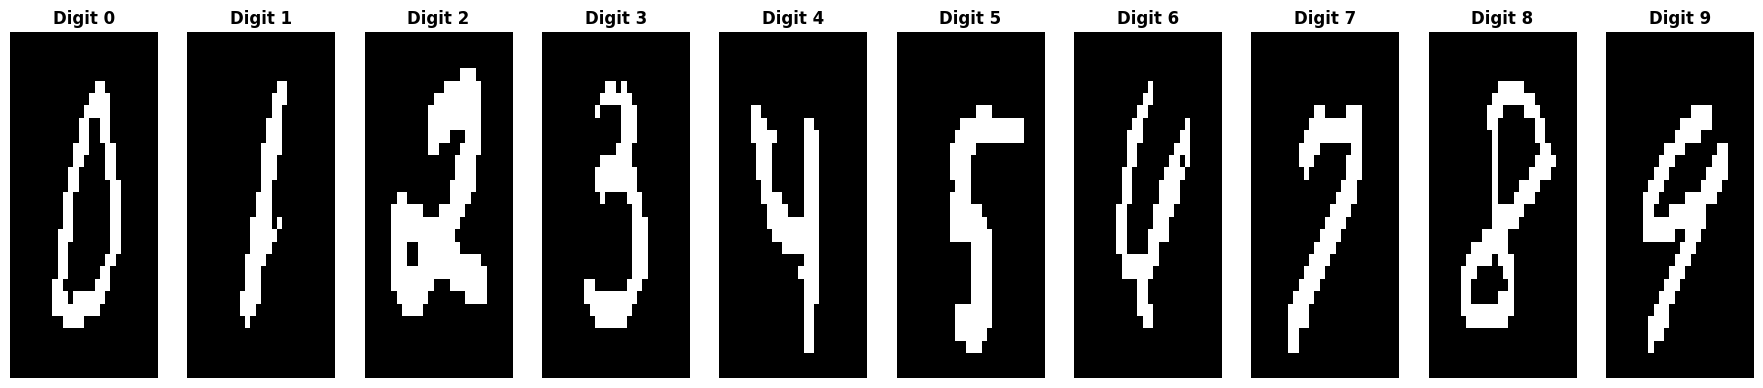

In [11]:
num_row, num_col = 1, 10
len_tr = len(x_train)
f, subplots = plt.subplots(num_row, num_col, sharex='col', sharey='row')

for cls in np.unique(y_train):
    idx = np.arange(len_tr)[y_train == cls]
    idx = np.random.choice(idx)
    X_img = x_train[idx]
    subplots[cls].imshow(X_img, cmap='gray',
                       interpolation='nearest', aspect='auto')
    subplots[cls].set_title(f'Digit {cls}', fontweight="bold")
    subplots[cls].grid(visible=False)
    subplots[cls].axis('off')

f.set_size_inches(22.5, 4.5)

**Step 1: training the Naive Bayes classifier on the training set.**

In [12]:
# get the model
nbc = NaiveBayesClassifier()

# train
nbc.fit(x_train, y_train)

# media, deviazione standard e varianza

**Step 2: evaluating the performance of the classifier on a set of unseen data (test set).**

Accuracy: 0.8442


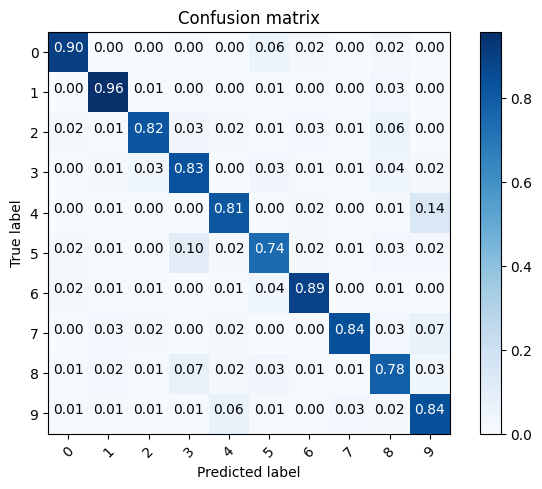

In [13]:
import itertools

def plot_confusion_matrix(targets, predictions, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    n_classes, = np.unique(targets).shape

    cm = np.zeros(shape=(n_classes, n_classes), dtype=np.float32)
    for t, p in zip(targets, predictions):
        cm[int(t), int(p)] += 1

    if normalize:
        cm /= cm.sum(axis=1)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# test
predictions = nbc.predict(x_test.reshape((len(x_test), -1)))

# evaluate performances
accuracy = np.sum(np.uint8(predictions == y_test)) / len(y_test)
print('Accuracy: {}'.format(accuracy))

# show confusion matrix
plot_confusion_matrix(targets=y_test,
                      predictions=predictions,
                      classes=[label_dict[l] for l in label_dict])

In [ ]:
idx = np.random.randint(0, x_test.shape[0])

x = x_test[idx]
p = predictions[idx]
y = y_test[idx]

plt.imshow(x, cmap='gray')
plt.title('Target: {}, Prediction: {}'.format(label_dict[int(y)], label_dict[int(p)]))